In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

In [2]:
# Setting hyperparameters
batch_size = 128
epochs = 200
learning_rate = 0.01
l1 = False
l2 = False
lr_decay = False

In [3]:
df1 = pd.read_csv("sml2010/NEW-DATA-1.T15.txt", sep = " ")
df2 = pd.read_csv("sml2010/NEW-DATA-2.T15.txt", sep = " ")
print(df1.shape)
print(df2.shape)

df = pd.concat([df1, df2], axis=0)

print(df.shape)

(2764, 26)
(1373, 26)
(4137, 26)


In [4]:
df.head()

,#,Unnamed: 1,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,...,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,95436.8,758.880,0,0,0,18.1150,48.3750,2.0,NaN,NaN
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,95436.8,762.069,0,0,0,18.4147,47.8080,2.0,NaN,NaN
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,95398.6,766.251,0,0,0,18.8533,47.4320,2.0,NaN,NaN
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,95360.3,766.037,0,0,0,19.2907,47.0240,2.0,NaN,NaN
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,95354.9,762.743,0,0,0,19.7400,45.4743,2.0,NaN,NaN


In [5]:
feature_list = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

target = '3:Temperature_Comedor_Sensor'

X = df[feature_list]
y = df[target]

In [6]:
print(X.isnull().sum())
print(y.isnull().sum())

3:Temperature_Comedor_Sensor       0
4:Temperature_Habitacion_Sensor    0
5:Weather_Temperature              0
6:CO2_Comedor_Sensor               0
7:CO2_Habitacion_Sensor            0
8:Humedad_Comedor_Sensor           0
9:Humedad_Habitacion_Sensor        0
10:Lighting_Comedor_Sensor         0
11:Lighting_Habitacion_Sensor      0
12:Precipitacion                   0
13:Meteo_Exterior_Crepusculo       0
14:Meteo_Exterior_Viento           0
15:Meteo_Exterior_Sol_Oest         0
16:Meteo_Exterior_Sol_Est          0
20:Exterior_Entalpic_2             0
21:Exterior_Entalpic_turbo         0
22:Temperature_Exterior_Sensor     0
dtype: int64
0


In [7]:
# Generating dataset

class sml2010(Dataset):
    def __init__(self, X, y, bias):
        self.X = X.to_numpy()
        self.y = y.to_numpy()
        self.bias = bias
        self.meta= self.preprocess(self.X, self.y)

    def preprocess(self, X, y):
        X_min, y_min = X.min(axis=0), y.min(axis=0)  
        X_max, y_max = X.max(axis=0), y.max(axis=0)  

        # X = (X - X_min)/(X_max - X_min + bias)
        # y = (y - y_min)/(y_max - y_min + bias)

        # X_train, y_train, xtemp, ytemp = train_test_split(X, y, test_size=tv, random_state=42)
        # X_val, y_val, X_test, y_test = train_test_split(xtemp, ytemp, test_size=vt, random_state=42)

        meta_data = [X_max, y_max, X_min, y_min]

        # return (X_train, X_val, X_test), (y_train, y_val, y_test), meta_data
        return meta_data

        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        p = (self.X[index, :] - self.meta[2])/(self.meta[0] - self.meta[2] + self.bias)
        q = (self.y[index] - self.meta[3])/(self.meta[1] - self.meta[3] + self.bias)
        return p,q

In [8]:
train = sml2010(X.iloc[:3500, :], y.iloc[:3500], 1e-4)
train.meta[0][2]

609.237

In [9]:
val = sml2010(X.iloc[3500:4000, :], y.iloc[3500:4000], 1e-4)
val.meta[0][2]

304.544

In [10]:
test = sml2010(X.iloc[4000:, :], y.iloc[4000:], 1e-4)
test.meta[0][2]

203.509

In [11]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False)

In [12]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([128, 17]) torch.Size([128])


In [13]:
type(features)

torch.Tensor

In [14]:
class RNNForecasting(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape, num_layers):
        super(RNNForecasting, self).__init__()
        self.hidden = hidden_shape
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_shape, hidden_shape, num_layers=num_layers)
        self.linear = nn.Linear(hidden_shape, output_shape)

    def forward(self, x):
        h = torch.zeros([self.num_layers, self.hidden], dtype=torch.double).cuda()
        # print(f"ff {h.dtype}")
        out, h = self.rnn(x, h)
        out = self.linear(out)
        return out   

In [15]:
input_shape = 17
hidden_shape = 256
model = RNNForecasting(input_shape, hidden_shape, 1, num_layers=3).double().cuda()

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

In [17]:
# Training
l1_weight = 0.01
l2_weight = 0.01
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        # print(batch_x.dtype)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        if l1:
            l1_parameters = []
            for parameter in model.parameters():
                l1_parameters.append(parameter.view(-1))
            L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
            l += L1

        # Using l2 regularization
        if l2:
            l2_parameters = []
            for parameter in model.parameters():
                l2_parameters.append(parameter.view(-1))
            L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
            l += L1      

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    if lr_decay:    
        epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
        
    print("Iter: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)


Iter:  0 train:  0.6210503207543494 val:  0.2502353734650404
Iter:  1 train:  0.15923332710203086 val:  0.2914894562608955
Iter:  2 train:  0.10996654251076464 val:  0.27120562053219055
Iter:  3 train:  0.09496134960558436 val:  0.11633048001296775
Iter:  4 train:  0.11666460579628063 val:  0.16015769102736008
Iter:  5 train:  0.07739544418095974 val:  0.22196518255347972
Iter:  6 train:  0.0600115709908753 val:  0.19857782176910524
Iter:  7 train:  0.04914755631097049 val:  0.2556666813254537
Iter:  8 train:  0.05274765856833158 val:  0.23586608318771304
Iter:  9 train:  0.05073103745675978 val:  0.23936848076070494
Iter:  10 train:  0.03868539305084505 val:  0.1531501677229836
Iter:  11 train:  0.05112579016219024 val:  0.2642831615458018
Iter:  12 train:  0.042920606494316275 val:  0.19668298008819815
Iter:  13 train:  0.031274604202666034 val:  0.16335874049018237
Iter:  14 train:  0.03696598849760564 val:  0.21612979947562008
Iter:  15 train:  0.05008890291170315 val:  0.200515457

0.05509142051209836 0.19715185599856147


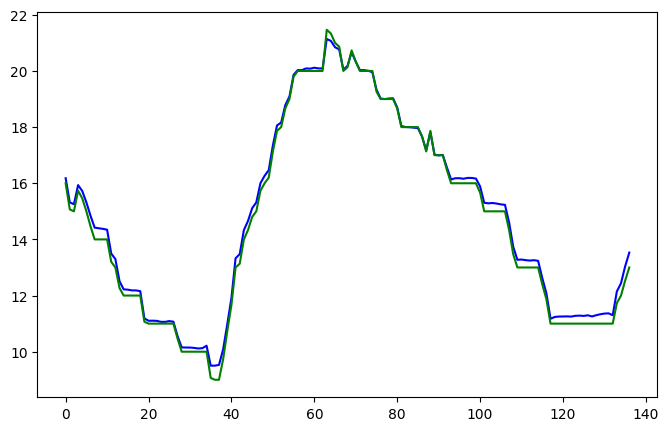

In [18]:
# Testing the model

with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    # resizing to true value scales
    preds = preds*(test.meta[1] - test.meta[3]) + test.meta[3]
    true = true*(test.meta[1] - test.meta[3]) + test.meta[3]

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

    plt.figure(figsize=(8, 5))
    plt.plot(preds, 'b', label='line 1')
    plt.plot(true, 'g',  label='line 2')
    plt.show()

In [20]:
# GRU (No decay no reg) - 5.446628169150186 2.0011579190842716
# GRU (with decay no reg) - 0.05509142051209836 0.19715185599856147